## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [18]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-06-13 08:55:39--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.104.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.104.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  70.8MB/s    in 4.7s    

2019-06-13 08:55:44 (68.1 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [19]:
import requests

KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"

response = requests.request("GET", TOKEN_URL, headers={"Metadata-Flavor":"Google"})
token = response.text


In [20]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()

print(net)

/home/workspace/models.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Net(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [22]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
# Perform data augmentation on train dataset by first scaling and then random cropping
data_transform_train = transforms.Compose([Rescale((250, 250)), \
                                           RandomCrop((227, 227)), \
                                           Normalize(), \
                                           ToTensor()])

data_transform_validation = transforms.Compose([Rescale((227, 227)), \
                                          Normalize(), \
                                          ToTensor()])

# testing that you've defined a transform
assert(data_transform_train is not None), 'Define a data_transform'

In [23]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform_train)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 227, 227]) torch.Size([68, 2])
1 torch.Size([1, 227, 227]) torch.Size([68, 2])
2 torch.Size([1, 227, 227]) torch.Size([68, 2])
3 torch.Size([1, 227, 227]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [24]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [25]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform_validation)



In [26]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [27]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [28]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [29]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

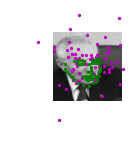

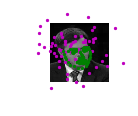

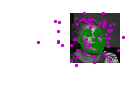

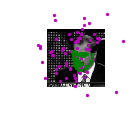

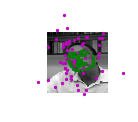

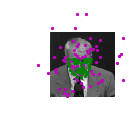

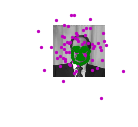

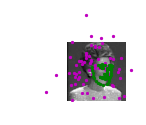

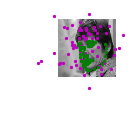

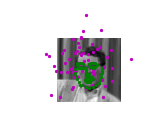

In [30]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        requests.request("POST", KEEPALIVE_URL , headers={'Authorization': "STAR " + token})
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
                         
            requests.request("POST", KEEPALIVE_URL , headers={'Authorization': "STAR " + token})
                             
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [16]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.7774089276790619
Epoch: 1, Batch: 20, Avg. Loss: 0.6667527735233307
Epoch: 1, Batch: 30, Avg. Loss: 0.5889659702777863
Epoch: 1, Batch: 40, Avg. Loss: 0.5385774910449982
Epoch: 1, Batch: 50, Avg. Loss: 0.47051590383052827
Epoch: 1, Batch: 60, Avg. Loss: 0.450872802734375
Epoch: 1, Batch: 70, Avg. Loss: 0.43655516803264616
Epoch: 1, Batch: 80, Avg. Loss: 0.44248646795749663
Epoch: 1, Batch: 90, Avg. Loss: 0.4085301995277405
Epoch: 1, Batch: 100, Avg. Loss: 0.4032630532979965
Epoch: 1, Batch: 110, Avg. Loss: 0.39928465485572817
Epoch: 1, Batch: 120, Avg. Loss: 0.37721340358257294
Epoch: 1, Batch: 130, Avg. Loss: 0.4009063482284546
Epoch: 1, Batch: 140, Avg. Loss: 0.37888291478157043
Epoch: 1, Batch: 150, Avg. Loss: 0.36769205033779145
Epoch: 1, Batch: 160, Avg. Loss: 0.36134717166423796
Epoch: 1, Batch: 170, Avg. Loss: 0.35927013754844667
Epoch: 1, Batch: 180, Avg. Loss: 0.3269973874092102
Epoch: 1, Batch: 190, Avg. Loss: 0.34130783677101134
Epoch: 1, Ba

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.2725637942552567
Epoch: 2, Batch: 20, Avg. Loss: 0.26511097699403763
Epoch: 2, Batch: 30, Avg. Loss: 0.2642239391803741
Epoch: 2, Batch: 40, Avg. Loss: 0.2718674376606941
Epoch: 2, Batch: 50, Avg. Loss: 0.25832618921995165
Epoch: 2, Batch: 60, Avg. Loss: 0.25366607755422593
Epoch: 2, Batch: 70, Avg. Loss: 0.25068811476230624
Epoch: 2, Batch: 80, Avg. Loss: 0.2600605472922325
Epoch: 2, Batch: 90, Avg. Loss: 0.23840388804674148
Epoch: 2, Batch: 100, Avg. Loss: 0.23097998052835464
Epoch: 2, Batch: 110, Avg. Loss: 0.2310661107301712
Epoch: 2, Batch: 120, Avg. Loss: 0.2307450070977211
Epoch: 2, Batch: 130, Avg. Loss: 0.2286609888076782
Epoch: 2, Batch: 140, Avg. Loss: 0.23218228816986083
Epoch: 2, Batch: 150, Avg. Loss: 0.21667300313711166
Epoch: 2, Batch: 160, Avg. Loss: 0.21787231266498566
Epoch: 2, Batch: 170, Avg. Loss: 0.2065810889005661
Epoch: 2, Batch: 180, Avg. Loss: 0.21392192095518112
Epoch: 2, Batch: 190, Avg. Loss: 0.21072217226028442
Epoch: 2, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.16765966713428498
Epoch: 3, Batch: 20, Avg. Loss: 0.17985538393259048
Epoch: 3, Batch: 30, Avg. Loss: 0.16731530278921128
Epoch: 3, Batch: 40, Avg. Loss: 0.16092268675565718
Epoch: 3, Batch: 50, Avg. Loss: 0.17538008093833923
Epoch: 3, Batch: 60, Avg. Loss: 0.16975789815187453
Epoch: 3, Batch: 70, Avg. Loss: 0.17373280823230744
Epoch: 3, Batch: 80, Avg. Loss: 0.1684708774089813
Epoch: 3, Batch: 90, Avg. Loss: 0.1582052916288376
Epoch: 3, Batch: 100, Avg. Loss: 0.16091623157262802
Epoch: 3, Batch: 110, Avg. Loss: 0.1506871312856674
Epoch: 3, Batch: 120, Avg. Loss: 0.1591564744710922
Epoch: 3, Batch: 130, Avg. Loss: 0.14744001477956772
Epoch: 3, Batch: 140, Avg. Loss: 0.1529301345348358
Epoch: 3, Batch: 150, Avg. Loss: 0.1500735491514206
Epoch: 3, Batch: 160, Avg. Loss: 0.14890055507421493
Epoch: 3, Batch: 170, Avg. Loss: 0.14237445145845412
Epoch: 3, Batch: 180, Avg. Loss: 0.15357402116060256
Epoch: 3, Batch: 190, Avg. Loss: 0.159253092110157
Epoch: 3, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.1252504326403141
Epoch: 4, Batch: 20, Avg. Loss: 0.11956072375178337
Epoch: 4, Batch: 30, Avg. Loss: 0.12712047025561332
Epoch: 4, Batch: 40, Avg. Loss: 0.12280330881476402
Epoch: 4, Batch: 50, Avg. Loss: 0.12551560550928115
Epoch: 4, Batch: 60, Avg. Loss: 0.12049884721636772
Epoch: 4, Batch: 70, Avg. Loss: 0.1179940052330494
Epoch: 4, Batch: 80, Avg. Loss: 0.12488719373941422
Epoch: 4, Batch: 90, Avg. Loss: 0.12161023244261741
Epoch: 4, Batch: 100, Avg. Loss: 0.11474020034074783
Epoch: 4, Batch: 110, Avg. Loss: 0.11037077456712723
Epoch: 4, Batch: 120, Avg. Loss: 0.1156611867249012
Epoch: 4, Batch: 130, Avg. Loss: 0.11257996708154679
Epoch: 4, Batch: 140, Avg. Loss: 0.10570546761155128
Epoch: 4, Batch: 150, Avg. Loss: 0.11296836510300637
Epoch: 4, Batch: 160, Avg. Loss: 0.10806430652737617
Epoch: 4, Batch: 170, Avg. Loss: 0.10630270391702652
Epoch: 4, Batch: 180, Avg. Loss: 0.10626988857984543
Epoch: 4, Batch: 190, Avg. Loss: 0.11268988475203515
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.09750604927539826
Epoch: 5, Batch: 20, Avg. Loss: 0.10512846559286118
Epoch: 5, Batch: 30, Avg. Loss: 0.09105933755636215
Epoch: 5, Batch: 40, Avg. Loss: 0.09948495030403137
Epoch: 5, Batch: 50, Avg. Loss: 0.08490420803427697
Epoch: 5, Batch: 60, Avg. Loss: 0.09754078611731529
Epoch: 5, Batch: 70, Avg. Loss: 0.089962287992239
Epoch: 5, Batch: 80, Avg. Loss: 0.0820268977433443
Epoch: 5, Batch: 90, Avg. Loss: 0.08905962705612183
Epoch: 5, Batch: 100, Avg. Loss: 0.08284057527780533
Epoch: 5, Batch: 110, Avg. Loss: 0.08745920211076737
Epoch: 5, Batch: 120, Avg. Loss: 0.08220430091023445
Epoch: 5, Batch: 130, Avg. Loss: 0.08557498157024383
Epoch: 5, Batch: 140, Avg. Loss: 0.08518677577376366
Epoch: 5, Batch: 150, Avg. Loss: 0.07711895294487477
Epoch: 5, Batch: 160, Avg. Loss: 0.08823637887835503
Epoch: 5, Batch: 170, Avg. Loss: 0.08517885208129883
Epoch: 5, Batch: 180, Avg. Loss: 0.07661559879779815
Epoch: 5, Batch: 190, Avg. Loss: 0.08063197769224643
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.07277122773230076
Epoch: 6, Batch: 20, Avg. Loss: 0.0706612404435873
Epoch: 6, Batch: 30, Avg. Loss: 0.07397934086620808
Epoch: 6, Batch: 40, Avg. Loss: 0.06980663016438485
Epoch: 6, Batch: 50, Avg. Loss: 0.06257083006203175
Epoch: 6, Batch: 60, Avg. Loss: 0.06861946359276772
Epoch: 6, Batch: 70, Avg. Loss: 0.06005947552621364
Epoch: 6, Batch: 80, Avg. Loss: 0.06801981814205646
Epoch: 6, Batch: 90, Avg. Loss: 0.07749850079417228
Epoch: 6, Batch: 100, Avg. Loss: 0.06099792756140232
Epoch: 6, Batch: 110, Avg. Loss: 0.07346439994871616
Epoch: 6, Batch: 120, Avg. Loss: 0.07032709121704102
Epoch: 6, Batch: 130, Avg. Loss: 0.07636467888951301
Epoch: 6, Batch: 140, Avg. Loss: 0.06967066712677479
Epoch: 6, Batch: 150, Avg. Loss: 0.06999623812735081
Epoch: 6, Batch: 160, Avg. Loss: 0.0714545976370573
Epoch: 6, Batch: 170, Avg. Loss: 0.06038994379341602
Epoch: 6, Batch: 180, Avg. Loss: 0.06238214336335659
Epoch: 6, Batch: 190, Avg. Loss: 0.0637990090996027
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.05097549967467785
Epoch: 7, Batch: 20, Avg. Loss: 0.05282476767897606
Epoch: 7, Batch: 30, Avg. Loss: 0.04957843460142612
Epoch: 7, Batch: 40, Avg. Loss: 0.04679292589426041
Epoch: 7, Batch: 50, Avg. Loss: 0.0478011179715395
Epoch: 7, Batch: 60, Avg. Loss: 0.05111860223114491
Epoch: 7, Batch: 70, Avg. Loss: 0.04711126573383808
Epoch: 7, Batch: 80, Avg. Loss: 0.048679334297776225
Epoch: 7, Batch: 90, Avg. Loss: 0.044262605533003804
Epoch: 7, Batch: 100, Avg. Loss: 0.03833465687930584
Epoch: 7, Batch: 110, Avg. Loss: 0.0513580746948719
Epoch: 7, Batch: 120, Avg. Loss: 0.05630640164017677
Epoch: 7, Batch: 130, Avg. Loss: 0.04360593929886818
Epoch: 7, Batch: 140, Avg. Loss: 0.04770354088395834
Epoch: 7, Batch: 150, Avg. Loss: 0.046242688596248624
Epoch: 7, Batch: 160, Avg. Loss: 0.045750648528337476
Epoch: 7, Batch: 170, Avg. Loss: 0.05046339426189661
Epoch: 7, Batch: 180, Avg. Loss: 0.046397847682237627
Epoch: 7, Batch: 190, Avg. Loss: 0.0432839073240757


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.044759430550038816
Epoch: 8, Batch: 20, Avg. Loss: 0.03973967619240284
Epoch: 8, Batch: 30, Avg. Loss: 0.03757742792367935
Epoch: 8, Batch: 40, Avg. Loss: 0.043056689016520974
Epoch: 8, Batch: 50, Avg. Loss: 0.03926829155534506
Epoch: 8, Batch: 60, Avg. Loss: 0.03495818171650171
Epoch: 8, Batch: 70, Avg. Loss: 0.042515836842358115
Epoch: 8, Batch: 80, Avg. Loss: 0.04255322087556124
Epoch: 8, Batch: 90, Avg. Loss: 0.03876901157200337
Epoch: 8, Batch: 100, Avg. Loss: 0.03906522374600172
Epoch: 8, Batch: 110, Avg. Loss: 0.043357210047543046
Epoch: 8, Batch: 120, Avg. Loss: 0.03547427486628294
Epoch: 8, Batch: 130, Avg. Loss: 0.040000741742551325
Epoch: 8, Batch: 140, Avg. Loss: 0.03281181398779154
Epoch: 8, Batch: 150, Avg. Loss: 0.040896937251091
Epoch: 8, Batch: 160, Avg. Loss: 0.03822906482964754
Epoch: 8, Batch: 170, Avg. Loss: 0.039149604737758636
Epoch: 8, Batch: 180, Avg. Loss: 0.043719021044671534
Epoch: 8, Batch: 190, Avg. Loss: 0.040522159636020

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.03642403818666935
Epoch: 9, Batch: 20, Avg. Loss: 0.031215783208608627
Epoch: 9, Batch: 30, Avg. Loss: 0.029098560102283955
Epoch: 9, Batch: 40, Avg. Loss: 0.03690154459327459
Epoch: 9, Batch: 50, Avg. Loss: 0.028650714084506035
Epoch: 9, Batch: 60, Avg. Loss: 0.029733948409557343
Epoch: 9, Batch: 70, Avg. Loss: 0.029932487383484842
Epoch: 9, Batch: 80, Avg. Loss: 0.03407713882625103
Epoch: 9, Batch: 90, Avg. Loss: 0.030887824855744837
Epoch: 9, Batch: 100, Avg. Loss: 0.02613170649856329
Epoch: 9, Batch: 110, Avg. Loss: 0.038303380087018016
Epoch: 9, Batch: 120, Avg. Loss: 0.033389529399573806
Epoch: 9, Batch: 130, Avg. Loss: 0.03473644256591797
Epoch: 9, Batch: 140, Avg. Loss: 0.03968990184366703
Epoch: 9, Batch: 150, Avg. Loss: 0.032085868529975414
Epoch: 9, Batch: 160, Avg. Loss: 0.03322719503194094
Epoch: 9, Batch: 170, Avg. Loss: 0.026600699312984942
Epoch: 9, Batch: 180, Avg. Loss: 0.030425555258989333
Epoch: 9, Batch: 190, Avg. Loss: 0.030451014

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.028146649338304998
Epoch: 10, Batch: 20, Avg. Loss: 0.025247838627547026
Epoch: 10, Batch: 30, Avg. Loss: 0.03456802852451801
Epoch: 10, Batch: 40, Avg. Loss: 0.022117506340146066
Epoch: 10, Batch: 50, Avg. Loss: 0.027257480286061765
Epoch: 10, Batch: 60, Avg. Loss: 0.029069923609495164
Epoch: 10, Batch: 70, Avg. Loss: 0.02584113087505102
Epoch: 10, Batch: 80, Avg. Loss: 0.03173169661313295
Epoch: 10, Batch: 90, Avg. Loss: 0.026846257410943507
Epoch: 10, Batch: 100, Avg. Loss: 0.02710524443536997
Epoch: 10, Batch: 110, Avg. Loss: 0.03523228820413351
Epoch: 10, Batch: 120, Avg. Loss: 0.022261630184948443
Epoch: 10, Batch: 130, Avg. Loss: 0.029272814095020295
Epoch: 10, Batch: 140, Avg. Loss: 0.022487972863018513
Epoch: 10, Batch: 150, Avg. Loss: 0.022314974572509527
Epoch: 10, Batch: 160, Avg. Loss: 0.023657472059130668
Epoch: 10, Batch: 170, Avg. Loss: 0.029642288386821748
Epoch: 10, Batch: 180, Avg. Loss: 0.024226171616464853
Epoch: 10, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.03307120967656374
Epoch: 11, Batch: 20, Avg. Loss: 0.03493119031190872
Epoch: 11, Batch: 30, Avg. Loss: 0.029252884536981584
Epoch: 11, Batch: 40, Avg. Loss: 0.034339590556919576
Epoch: 11, Batch: 50, Avg. Loss: 0.025547419674694538
Epoch: 11, Batch: 60, Avg. Loss: 0.027400046214461328
Epoch: 11, Batch: 70, Avg. Loss: 0.026256599463522434
Epoch: 11, Batch: 80, Avg. Loss: 0.027048559859395027
Epoch: 11, Batch: 90, Avg. Loss: 0.025585165433585643
Epoch: 11, Batch: 100, Avg. Loss: 0.028200709261000156
Epoch: 11, Batch: 110, Avg. Loss: 0.021703536808490752
Epoch: 11, Batch: 120, Avg. Loss: 0.02341064028441906
Epoch: 11, Batch: 130, Avg. Loss: 0.023689990863204002
Epoch: 11, Batch: 140, Avg. Loss: 0.024542115069925784
Epoch: 11, Batch: 150, Avg. Loss: 0.025672873295843602
Epoch: 11, Batch: 160, Avg. Loss: 0.02123502129688859
Epoch: 11, Batch: 170, Avg. Loss: 0.02451179102063179
Epoch: 11, Batch: 180, Avg. Loss: 0.020149209164083005
Epoch: 11, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.03714205101132393
Epoch: 12, Batch: 20, Avg. Loss: 0.0441389137879014
Epoch: 12, Batch: 30, Avg. Loss: 0.04243478756397963
Epoch: 12, Batch: 40, Avg. Loss: 0.037875302322208884
Epoch: 12, Batch: 50, Avg. Loss: 0.03835772760212421
Epoch: 12, Batch: 60, Avg. Loss: 0.036124033480882646
Epoch: 12, Batch: 70, Avg. Loss: 0.03354244641959667
Epoch: 12, Batch: 80, Avg. Loss: 0.033554117381572726
Epoch: 12, Batch: 90, Avg. Loss: 0.03805840630084276
Epoch: 12, Batch: 100, Avg. Loss: 0.03414354231208563
Epoch: 12, Batch: 110, Avg. Loss: 0.028529896028339864
Epoch: 12, Batch: 120, Avg. Loss: 0.03187442068010569
Epoch: 12, Batch: 130, Avg. Loss: 0.02977512273937464
Epoch: 12, Batch: 140, Avg. Loss: 0.03427922390401363
Epoch: 12, Batch: 150, Avg. Loss: 0.030291100684553384
Epoch: 12, Batch: 160, Avg. Loss: 0.03452076371759176
Epoch: 12, Batch: 170, Avg. Loss: 0.0278182964771986
Epoch: 12, Batch: 180, Avg. Loss: 0.02805753406137228
Epoch: 12, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.02443955820053816
Epoch: 13, Batch: 20, Avg. Loss: 0.02788509037345648
Epoch: 13, Batch: 30, Avg. Loss: 0.028147372230887414
Epoch: 13, Batch: 40, Avg. Loss: 0.02824577409774065
Epoch: 13, Batch: 50, Avg. Loss: 0.025280654802918433
Epoch: 13, Batch: 60, Avg. Loss: 0.02809080174192786
Epoch: 13, Batch: 70, Avg. Loss: 0.025153115577995776
Epoch: 13, Batch: 80, Avg. Loss: 0.024582989513874054
Epoch: 13, Batch: 90, Avg. Loss: 0.02885491158813238
Epoch: 13, Batch: 100, Avg. Loss: 0.022495506051927804
Epoch: 13, Batch: 110, Avg. Loss: 0.02772918567061424
Epoch: 13, Batch: 120, Avg. Loss: 0.021600925456732513
Epoch: 13, Batch: 130, Avg. Loss: 0.025976385176181793
Epoch: 13, Batch: 140, Avg. Loss: 0.02127689039334655
Epoch: 13, Batch: 150, Avg. Loss: 0.02664150344207883
Epoch: 13, Batch: 160, Avg. Loss: 0.027496475819498302
Epoch: 13, Batch: 170, Avg. Loss: 0.033082562312483785
Epoch: 13, Batch: 180, Avg. Loss: 0.02259722165763378
Epoch: 13, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.02307890970259905
Epoch: 14, Batch: 20, Avg. Loss: 0.018737956508994104
Epoch: 14, Batch: 30, Avg. Loss: 0.021270648576319218
Epoch: 14, Batch: 40, Avg. Loss: 0.025419819727540018
Epoch: 14, Batch: 50, Avg. Loss: 0.02285917568951845
Epoch: 14, Batch: 60, Avg. Loss: 0.022508514858782292
Epoch: 14, Batch: 70, Avg. Loss: 0.01842892896384001
Epoch: 14, Batch: 80, Avg. Loss: 0.024258195888251066
Epoch: 14, Batch: 90, Avg. Loss: 0.025290628708899022
Epoch: 14, Batch: 100, Avg. Loss: 0.01624841531738639
Epoch: 14, Batch: 110, Avg. Loss: 0.021031288150697946
Epoch: 14, Batch: 120, Avg. Loss: 0.025565519090741874
Epoch: 14, Batch: 130, Avg. Loss: 0.016893860790878533
Epoch: 14, Batch: 140, Avg. Loss: 0.024435077514499425
Epoch: 14, Batch: 150, Avg. Loss: 0.01764431018382311
Epoch: 14, Batch: 160, Avg. Loss: 0.0236187026835978
Epoch: 14, Batch: 170, Avg. Loss: 0.02204591277986765
Epoch: 14, Batch: 180, Avg. Loss: 0.021445852890610694
Epoch: 14, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.02021805290132761
Epoch: 15, Batch: 20, Avg. Loss: 0.015811573714017868
Epoch: 15, Batch: 30, Avg. Loss: 0.022594226989895105
Epoch: 15, Batch: 40, Avg. Loss: 0.01910949507728219
Epoch: 15, Batch: 50, Avg. Loss: 0.021295894775539635
Epoch: 15, Batch: 60, Avg. Loss: 0.0191148366779089
Epoch: 15, Batch: 70, Avg. Loss: 0.01693894751369953
Epoch: 15, Batch: 80, Avg. Loss: 0.019851553719490767
Epoch: 15, Batch: 90, Avg. Loss: 0.018296278081834316
Epoch: 15, Batch: 100, Avg. Loss: 0.015658258367329835
Epoch: 15, Batch: 110, Avg. Loss: 0.02202946050092578
Epoch: 15, Batch: 120, Avg. Loss: 0.017833011411130428
Epoch: 15, Batch: 130, Avg. Loss: 0.022319230902940034
Epoch: 15, Batch: 140, Avg. Loss: 0.02199889924377203
Epoch: 15, Batch: 150, Avg. Loss: 0.0158110317774117
Epoch: 15, Batch: 160, Avg. Loss: 0.02039058320224285
Epoch: 15, Batch: 170, Avg. Loss: 0.01842609643936157
Epoch: 15, Batch: 180, Avg. Loss: 0.01534296413883567
Epoch: 15, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.018045279663056135
Epoch: 16, Batch: 20, Avg. Loss: 0.01727589424699545
Epoch: 16, Batch: 30, Avg. Loss: 0.01808092212304473
Epoch: 16, Batch: 40, Avg. Loss: 0.018718059360980987
Epoch: 16, Batch: 50, Avg. Loss: 0.018543741293251516
Epoch: 16, Batch: 60, Avg. Loss: 0.022348714433610438
Epoch: 16, Batch: 70, Avg. Loss: 0.020044150436297058
Epoch: 16, Batch: 80, Avg. Loss: 0.02250262852758169
Epoch: 16, Batch: 90, Avg. Loss: 0.0192991578951478
Epoch: 16, Batch: 100, Avg. Loss: 0.015953614749014376
Epoch: 16, Batch: 110, Avg. Loss: 0.02335843089967966
Epoch: 16, Batch: 120, Avg. Loss: 0.016303906962275506
Epoch: 16, Batch: 130, Avg. Loss: 0.01767136137932539
Epoch: 16, Batch: 140, Avg. Loss: 0.015952739305794238
Epoch: 16, Batch: 150, Avg. Loss: 0.016800805926322937
Epoch: 16, Batch: 160, Avg. Loss: 0.016323177330195903
Epoch: 16, Batch: 170, Avg. Loss: 0.01720638610422611
Epoch: 16, Batch: 180, Avg. Loss: 0.017542136926203968
Epoch: 16, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.019302612356841563
Epoch: 17, Batch: 20, Avg. Loss: 0.01597487535327673
Epoch: 17, Batch: 30, Avg. Loss: 0.016134150605648757
Epoch: 17, Batch: 40, Avg. Loss: 0.01956943767145276
Epoch: 17, Batch: 50, Avg. Loss: 0.019552710559219123
Epoch: 17, Batch: 60, Avg. Loss: 0.02020617201924324
Epoch: 17, Batch: 70, Avg. Loss: 0.01854947367683053
Epoch: 17, Batch: 80, Avg. Loss: 0.017275889683514834
Epoch: 17, Batch: 90, Avg. Loss: 0.016482637729495764
Epoch: 17, Batch: 100, Avg. Loss: 0.015980976261198522
Epoch: 17, Batch: 110, Avg. Loss: 0.020123082119971512
Epoch: 17, Batch: 120, Avg. Loss: 0.01952017890289426
Epoch: 17, Batch: 130, Avg. Loss: 0.019525050930678845
Epoch: 17, Batch: 140, Avg. Loss: 0.014181690756231546
Epoch: 17, Batch: 150, Avg. Loss: 0.016793175786733627
Epoch: 17, Batch: 160, Avg. Loss: 0.017965396400541067
Epoch: 17, Batch: 170, Avg. Loss: 0.021249896939843894
Epoch: 17, Batch: 180, Avg. Loss: 0.01358686788007617
Epoch: 17, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.016158859245479107
Epoch: 18, Batch: 20, Avg. Loss: 0.012821643054485321
Epoch: 18, Batch: 30, Avg. Loss: 0.014267979003489018
Epoch: 18, Batch: 40, Avg. Loss: 0.014614765346050263
Epoch: 18, Batch: 50, Avg. Loss: 0.017522453796118498
Epoch: 18, Batch: 60, Avg. Loss: 0.015032726107165217
Epoch: 18, Batch: 70, Avg. Loss: 0.01327605964615941
Epoch: 18, Batch: 80, Avg. Loss: 0.014384851697832346
Epoch: 18, Batch: 90, Avg. Loss: 0.017978692427277565
Epoch: 18, Batch: 100, Avg. Loss: 0.0173080300912261
Epoch: 18, Batch: 110, Avg. Loss: 0.016735668666660784
Epoch: 18, Batch: 120, Avg. Loss: 0.018379613244906067
Epoch: 18, Batch: 130, Avg. Loss: 0.018169547989964487
Epoch: 18, Batch: 140, Avg. Loss: 0.015450420975685119
Epoch: 18, Batch: 150, Avg. Loss: 0.015919287269935013
Epoch: 18, Batch: 160, Avg. Loss: 0.017320842389017342
Epoch: 18, Batch: 170, Avg. Loss: 0.013242200668901204
Epoch: 18, Batch: 180, Avg. Loss: 0.014594025537371635
Epoch: 18, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.014847830077633262
Epoch: 19, Batch: 20, Avg. Loss: 0.014617371931672096
Epoch: 19, Batch: 30, Avg. Loss: 0.014307342562824487
Epoch: 19, Batch: 40, Avg. Loss: 0.013823500555008649
Epoch: 19, Batch: 50, Avg. Loss: 0.017415292840451003
Epoch: 19, Batch: 60, Avg. Loss: 0.02373591102659702
Epoch: 19, Batch: 70, Avg. Loss: 0.018940382078289984
Epoch: 19, Batch: 80, Avg. Loss: 0.015075645549222827
Epoch: 19, Batch: 90, Avg. Loss: 0.016837353445589544
Epoch: 19, Batch: 100, Avg. Loss: 0.01784644220024347
Epoch: 19, Batch: 110, Avg. Loss: 0.0192195319570601
Epoch: 19, Batch: 120, Avg. Loss: 0.015582367777824402
Epoch: 19, Batch: 130, Avg. Loss: 0.014450909197330475
Epoch: 19, Batch: 140, Avg. Loss: 0.015713388938456772
Epoch: 19, Batch: 150, Avg. Loss: 0.01430844534188509
Epoch: 19, Batch: 160, Avg. Loss: 0.017187122348695995
Epoch: 19, Batch: 170, Avg. Loss: 0.019827053509652616
Epoch: 19, Batch: 180, Avg. Loss: 0.013882762938737869
Epoch: 19, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.015823219902813435
Epoch: 20, Batch: 20, Avg. Loss: 0.01656000278890133
Epoch: 20, Batch: 30, Avg. Loss: 0.018087232019752264
Epoch: 20, Batch: 40, Avg. Loss: 0.020501737389713524
Epoch: 20, Batch: 50, Avg. Loss: 0.015466305054724216
Epoch: 20, Batch: 60, Avg. Loss: 0.017523239832371473
Epoch: 20, Batch: 70, Avg. Loss: 0.017414699029177427
Epoch: 20, Batch: 80, Avg. Loss: 0.01687539592385292
Epoch: 20, Batch: 90, Avg. Loss: 0.015050486102700234
Epoch: 20, Batch: 100, Avg. Loss: 0.019508088659495115
Epoch: 20, Batch: 110, Avg. Loss: 0.014779101684689521
Epoch: 20, Batch: 120, Avg. Loss: 0.015576761867851018
Epoch: 20, Batch: 130, Avg. Loss: 0.015416277572512627
Epoch: 20, Batch: 140, Avg. Loss: 0.014716847334057093
Epoch: 20, Batch: 150, Avg. Loss: 0.015101033495739102
Epoch: 20, Batch: 160, Avg. Loss: 0.017304808273911475
Epoch: 20, Batch: 170, Avg. Loss: 0.015525689721107483
Epoch: 20, Batch: 180, Avg. Loss: 0.011926296539604664
Epoch: 20, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.015698067843914032
Epoch: 21, Batch: 20, Avg. Loss: 0.013535639643669129
Epoch: 21, Batch: 30, Avg. Loss: 0.012136841844767331
Epoch: 21, Batch: 40, Avg. Loss: 0.014167416794225573
Epoch: 21, Batch: 50, Avg. Loss: 0.010061753541231155
Epoch: 21, Batch: 60, Avg. Loss: 0.017293217219412328
Epoch: 21, Batch: 70, Avg. Loss: 0.017847826518118382
Epoch: 21, Batch: 80, Avg. Loss: 0.016650171391665934
Epoch: 21, Batch: 90, Avg. Loss: 0.015291137527674437
Epoch: 21, Batch: 100, Avg. Loss: 0.013945658411830663
Epoch: 21, Batch: 110, Avg. Loss: 0.01470432262867689
Epoch: 21, Batch: 120, Avg. Loss: 0.012263847561553121
Epoch: 21, Batch: 130, Avg. Loss: 0.017620772263035177
Epoch: 21, Batch: 140, Avg. Loss: 0.011081743333488703
Epoch: 21, Batch: 150, Avg. Loss: 0.012578965444117785
Epoch: 21, Batch: 160, Avg. Loss: 0.011781555181369186
Epoch: 21, Batch: 170, Avg. Loss: 0.013553444109857083
Epoch: 21, Batch: 180, Avg. Loss: 0.013329899311065674
Epoch: 21, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.020227411203086375
Epoch: 22, Batch: 20, Avg. Loss: 0.024754613079130648
Epoch: 22, Batch: 30, Avg. Loss: 0.020961754117161037
Epoch: 22, Batch: 40, Avg. Loss: 0.026075764279812574
Epoch: 22, Batch: 50, Avg. Loss: 0.018422900699079037
Epoch: 22, Batch: 60, Avg. Loss: 0.018960182927548884
Epoch: 22, Batch: 70, Avg. Loss: 0.020020715612918138
Epoch: 22, Batch: 80, Avg. Loss: 0.01518369922414422
Epoch: 22, Batch: 90, Avg. Loss: 0.0164424242451787
Epoch: 22, Batch: 100, Avg. Loss: 0.015188694931566715
Epoch: 22, Batch: 110, Avg. Loss: 0.021131230611354114
Epoch: 22, Batch: 120, Avg. Loss: 0.01902419198304415
Epoch: 22, Batch: 130, Avg. Loss: 0.01742294253781438
Epoch: 22, Batch: 140, Avg. Loss: 0.022012393176555633
Epoch: 22, Batch: 150, Avg. Loss: 0.01426243269816041
Epoch: 22, Batch: 160, Avg. Loss: 0.018819406814873218
Epoch: 22, Batch: 170, Avg. Loss: 0.014629451977089047
Epoch: 22, Batch: 180, Avg. Loss: 0.0128823843318969
Epoch: 22, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.012972285598516464
Epoch: 23, Batch: 20, Avg. Loss: 0.014199973177164793
Epoch: 23, Batch: 30, Avg. Loss: 0.011895330622792244
Epoch: 23, Batch: 40, Avg. Loss: 0.01777992621064186
Epoch: 23, Batch: 50, Avg. Loss: 0.015171377081423998
Epoch: 23, Batch: 60, Avg. Loss: 0.0166608976200223
Epoch: 23, Batch: 70, Avg. Loss: 0.01603579046204686
Epoch: 23, Batch: 80, Avg. Loss: 0.013748709065839648
Epoch: 23, Batch: 90, Avg. Loss: 0.019907753448933363
Epoch: 23, Batch: 100, Avg. Loss: 0.014942053891718387
Epoch: 23, Batch: 110, Avg. Loss: 0.015347289200872184
Epoch: 23, Batch: 120, Avg. Loss: 0.014290649071335792
Epoch: 23, Batch: 130, Avg. Loss: 0.010799204185605048
Epoch: 23, Batch: 140, Avg. Loss: 0.011954555474221706
Epoch: 23, Batch: 150, Avg. Loss: 0.014593163412064314
Epoch: 23, Batch: 160, Avg. Loss: 0.016150965820997953
Epoch: 23, Batch: 170, Avg. Loss: 0.014076923672109842
Epoch: 23, Batch: 180, Avg. Loss: 0.012177982274442911
Epoch: 23, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.015443109348416329
Epoch: 24, Batch: 20, Avg. Loss: 0.01642147535458207
Epoch: 24, Batch: 30, Avg. Loss: 0.019665099401026963
Epoch: 24, Batch: 40, Avg. Loss: 0.017740115337073804
Epoch: 24, Batch: 50, Avg. Loss: 0.014733219984918833
Epoch: 24, Batch: 60, Avg. Loss: 0.01472624745219946
Epoch: 24, Batch: 70, Avg. Loss: 0.014505693176761269
Epoch: 24, Batch: 80, Avg. Loss: 0.014600049518048764
Epoch: 24, Batch: 90, Avg. Loss: 0.0155418680049479
Epoch: 24, Batch: 100, Avg. Loss: 0.012874749675393104
Epoch: 24, Batch: 110, Avg. Loss: 0.014985929382964969
Epoch: 24, Batch: 120, Avg. Loss: 0.01761245387606323
Epoch: 24, Batch: 130, Avg. Loss: 0.018018802907317878
Epoch: 24, Batch: 140, Avg. Loss: 0.01207359521649778
Epoch: 24, Batch: 150, Avg. Loss: 0.017365590017288924
Epoch: 24, Batch: 160, Avg. Loss: 0.017928817216306923
Epoch: 24, Batch: 170, Avg. Loss: 0.010306775756180286
Epoch: 24, Batch: 180, Avg. Loss: 0.011296034790575504
Epoch: 24, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.013817411568015813
Epoch: 25, Batch: 20, Avg. Loss: 0.013228198373690247
Epoch: 25, Batch: 30, Avg. Loss: 0.015676792431622743
Epoch: 25, Batch: 40, Avg. Loss: 0.01714701307937503
Epoch: 25, Batch: 50, Avg. Loss: 0.011871502827852964
Epoch: 25, Batch: 60, Avg. Loss: 0.01440555127337575
Epoch: 25, Batch: 70, Avg. Loss: 0.012229905556887388
Epoch: 25, Batch: 80, Avg. Loss: 0.011440623179078102
Epoch: 25, Batch: 90, Avg. Loss: 0.017727766092866658
Epoch: 25, Batch: 100, Avg. Loss: 0.013642950542271137
Epoch: 25, Batch: 110, Avg. Loss: 0.019926631078124046
Epoch: 25, Batch: 120, Avg. Loss: 0.014432654064148665
Epoch: 25, Batch: 130, Avg. Loss: 0.012453765189275146
Epoch: 25, Batch: 140, Avg. Loss: 0.011509390827268363
Epoch: 25, Batch: 150, Avg. Loss: 0.010750113055109978
Epoch: 25, Batch: 160, Avg. Loss: 0.01299075661227107
Epoch: 25, Batch: 170, Avg. Loss: 0.012307501677423716
Epoch: 25, Batch: 180, Avg. Loss: 0.013729126751422882
Epoch: 25, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.011481548240408302
Epoch: 26, Batch: 20, Avg. Loss: 0.01062069796025753
Epoch: 26, Batch: 30, Avg. Loss: 0.011168650910258293
Epoch: 26, Batch: 40, Avg. Loss: 0.013315307581797243
Epoch: 26, Batch: 50, Avg. Loss: 0.012525491928681732
Epoch: 26, Batch: 60, Avg. Loss: 0.015618388494476675
Epoch: 26, Batch: 70, Avg. Loss: 0.012512070266529918
Epoch: 26, Batch: 80, Avg. Loss: 0.01295528169721365
Epoch: 26, Batch: 90, Avg. Loss: 0.013095836760476232
Epoch: 26, Batch: 100, Avg. Loss: 0.017462240252643823
Epoch: 26, Batch: 110, Avg. Loss: 0.01364829046651721
Epoch: 26, Batch: 120, Avg. Loss: 0.011866656318306922
Epoch: 26, Batch: 130, Avg. Loss: 0.01492447331547737
Epoch: 26, Batch: 140, Avg. Loss: 0.012677527079358698
Epoch: 26, Batch: 150, Avg. Loss: 0.012053749989718199
Epoch: 26, Batch: 160, Avg. Loss: 0.011815102910622955
Epoch: 26, Batch: 170, Avg. Loss: 0.014091605925932527
Epoch: 26, Batch: 180, Avg. Loss: 0.009732585586607456
Epoch: 26, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.01179761434905231
Epoch: 27, Batch: 20, Avg. Loss: 0.010862006945535541
Epoch: 27, Batch: 30, Avg. Loss: 0.011855476396158337
Epoch: 27, Batch: 40, Avg. Loss: 0.011909924913197756
Epoch: 27, Batch: 50, Avg. Loss: 0.011251878505572677
Epoch: 27, Batch: 60, Avg. Loss: 0.012777087464928626
Epoch: 27, Batch: 70, Avg. Loss: 0.012364375870674849
Epoch: 27, Batch: 80, Avg. Loss: 0.010932029504328967
Epoch: 27, Batch: 90, Avg. Loss: 0.014899313636124133
Epoch: 27, Batch: 100, Avg. Loss: 0.013395505445078015
Epoch: 27, Batch: 110, Avg. Loss: 0.011385262152180076
Epoch: 27, Batch: 120, Avg. Loss: 0.016133578820154072
Epoch: 27, Batch: 130, Avg. Loss: 0.011600626353174447
Epoch: 27, Batch: 140, Avg. Loss: 0.01607612697407603
Epoch: 27, Batch: 150, Avg. Loss: 0.00990899996832013
Epoch: 27, Batch: 160, Avg. Loss: 0.015024936106055976
Epoch: 27, Batch: 170, Avg. Loss: 0.013018893031403422
Epoch: 27, Batch: 180, Avg. Loss: 0.011708237137645483
Epoch: 27, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.010284107411280274
Epoch: 28, Batch: 20, Avg. Loss: 0.009936407348141075
Epoch: 28, Batch: 30, Avg. Loss: 0.011871754610911011
Epoch: 28, Batch: 40, Avg. Loss: 0.013381868414580823
Epoch: 28, Batch: 50, Avg. Loss: 0.014208107255399227
Epoch: 28, Batch: 60, Avg. Loss: 0.014215678721666337
Epoch: 28, Batch: 70, Avg. Loss: 0.012298927875235677
Epoch: 28, Batch: 80, Avg. Loss: 0.013244237331673504
Epoch: 28, Batch: 90, Avg. Loss: 0.013905932707712055
Epoch: 28, Batch: 100, Avg. Loss: 0.01254205140285194
Epoch: 28, Batch: 110, Avg. Loss: 0.013971750810742378
Epoch: 28, Batch: 120, Avg. Loss: 0.011177864344790577
Epoch: 28, Batch: 130, Avg. Loss: 0.012200589897111059
Epoch: 28, Batch: 140, Avg. Loss: 0.01325689498335123
Epoch: 28, Batch: 150, Avg. Loss: 0.013859368208795787
Epoch: 28, Batch: 160, Avg. Loss: 0.013218976883217692
Epoch: 28, Batch: 170, Avg. Loss: 0.010222506010904908
Epoch: 28, Batch: 180, Avg. Loss: 0.011398314870893956
Epoch: 28, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.01401559729129076
Epoch: 29, Batch: 20, Avg. Loss: 0.011261304933577776
Epoch: 29, Batch: 30, Avg. Loss: 0.009900237480178476
Epoch: 29, Batch: 40, Avg. Loss: 0.012621755106374621
Epoch: 29, Batch: 50, Avg. Loss: 0.012799094198271632
Epoch: 29, Batch: 60, Avg. Loss: 0.014113090187311172
Epoch: 29, Batch: 70, Avg. Loss: 0.011086186207830907
Epoch: 29, Batch: 80, Avg. Loss: 0.012709826231002808
Epoch: 29, Batch: 90, Avg. Loss: 0.01171828587539494
Epoch: 29, Batch: 100, Avg. Loss: 0.010579289123415946
Epoch: 29, Batch: 110, Avg. Loss: 0.014107809681445361
Epoch: 29, Batch: 120, Avg. Loss: 0.012326240399852395
Epoch: 29, Batch: 130, Avg. Loss: 0.011411988362669944
Epoch: 29, Batch: 140, Avg. Loss: 0.010208368254825472
Epoch: 29, Batch: 150, Avg. Loss: 0.011905014980584383
Epoch: 29, Batch: 160, Avg. Loss: 0.01670648017898202
Epoch: 29, Batch: 170, Avg. Loss: 0.016771485470235346
Epoch: 29, Batch: 180, Avg. Loss: 0.011026077345013619
Epoch: 29, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.015069389902055263
Epoch: 30, Batch: 20, Avg. Loss: 0.01274247569963336
Epoch: 30, Batch: 30, Avg. Loss: 0.015142020490020513
Epoch: 30, Batch: 40, Avg. Loss: 0.017249942198395728
Epoch: 30, Batch: 50, Avg. Loss: 0.017555913608521222
Epoch: 30, Batch: 60, Avg. Loss: 0.01612963853403926
Epoch: 30, Batch: 70, Avg. Loss: 0.01654954724945128
Epoch: 30, Batch: 80, Avg. Loss: 0.015798761369660498
Epoch: 30, Batch: 90, Avg. Loss: 0.014157913438975812
Epoch: 30, Batch: 100, Avg. Loss: 0.015465823514387012
Epoch: 30, Batch: 110, Avg. Loss: 0.023493963479995727
Epoch: 30, Batch: 120, Avg. Loss: 0.014825190789997578
Epoch: 30, Batch: 130, Avg. Loss: 0.02058178521692753
Epoch: 30, Batch: 140, Avg. Loss: 0.013521604519337416
Epoch: 30, Batch: 150, Avg. Loss: 0.012715240102261305
Epoch: 30, Batch: 160, Avg. Loss: 0.016208296455442906
Epoch: 30, Batch: 170, Avg. Loss: 0.013980047078803182
Epoch: 30, Batch: 180, Avg. Loss: 0.012206183932721614
Epoch: 30, Batch: 190, 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


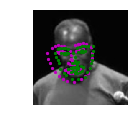

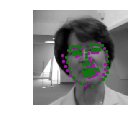

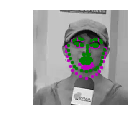

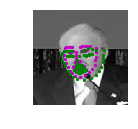

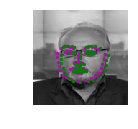

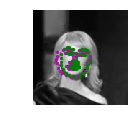

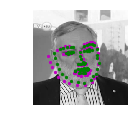

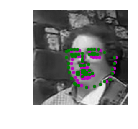

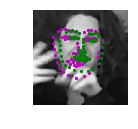

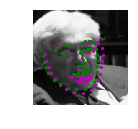

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_Paul_2nd.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
I used Adam's optimizer, with the learning rate set to 0.001, the betas coefficients used for computing running averages of gradient and its square set to 0.99 and 0.999 and the epsilon (term added to the denominator to improve numerical stability) set to the default 1e-08.
I used the Smooth L1 loss which is less sensitive to outliers compared to other regression loss functions, incl. L1 and L2, while preventing exploding gradients.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I used an AlexNet architecture with 1x227x227 input size, with an exponential linear unit activation function and several reguralization techniques to avoid overfitting, including Max Pooling layers, dropout layers and batch normalization.

ELU becomes smooth slowly, unlike to ReLU, and capable to produce negative outputs as well.

I also used Glorot (also known as Xavier) Initialization, which will initialize each weight with a small Gaussian value with mean=0 and the variance based on the fan-in (number of incoming network connections to the layer) and fan-out (number of outgoing network connections from that layer) of the weight.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: used 30 epochs and a batch size of 10 with 320 gradients updates for each epoch.

While increasing the number of epochs I haven't seen any significant improvement beyond 25. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.05807934  0.0142785  -0.03989493 -0.01928433]
 [-0.04756761  0.06013163 -0.00033034  0.05490663]
 [-0.05681321  0.00299822  0.05328093  0.0328624 ]
 [ 0.00398788 -0.03469727 -0.00699395  0.02088374]]
(4, 4)


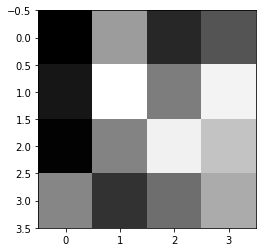

In [30]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

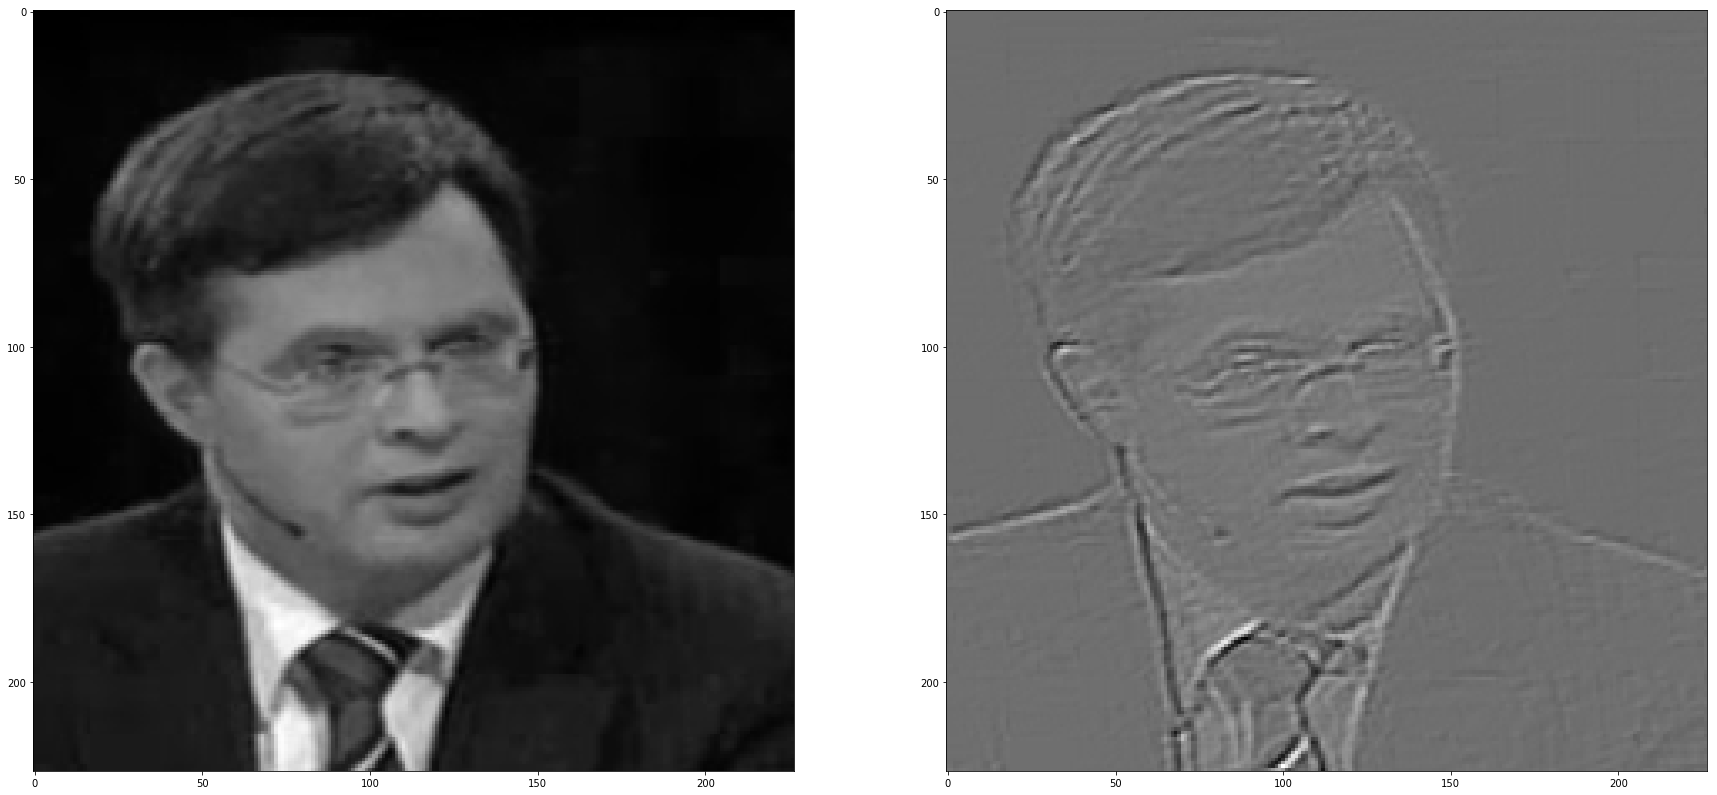

In [36]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

plt.figure(figsize=(30,15))
plt.subplot(1, 2, 1)

tranformed_image = test_images[1].data
tranformed_image = tranformed_image.cpu().numpy()

tranformed_image = np.transpose(tranformed_image, (1, 2, 0))
tranformed_image = np.squeeze(tranformed_image)
plt.imshow(tranformed_image, cmap='gray')

plt.subplot(1,2,2)

AlexNet_Weights = net.conv1.weight.data
Weights = AlexNet_Weights.cpu().numpy()


filtered_image = cv2.filter2D(tranformed_image, -1, Weights[0][0])
plt.imshow(filtered_image, cmap='gray')



### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) 
It seems the spatial pattern realized after filtering the image with the weights of the 1st convolutional layer, would mostly detect vertical lines. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!